## LorentzianClassification

In [ ]:
import logging
import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import cdist
from enum import IntEnum
import mplfinance as mpf
import yfinance as yf
import traceback
import matplotlib.pyplot as plt
 

# Set up logging
logging.basicConfig(
    level=logging.DEBUG,
    filename='application.log',  # Name of the log file
    filemode='w',  # 'w' to overwrite the log file on each run, 'a' to append
    format='%(asctime)s - %(levelname)s - %(message)s'
)

# The following functions are custom implementations of popular technical indicators used in trading.
# These indicators are typically used to analyze financial markets and make trading decisions.

def custom_rsi(data: pd.Series, period: int) -> pd.Series:
    """
    Calculates the Relative Strength Index (RSI).
    RSI is a momentum oscillator that measures the speed and change of price movements.
    
    Args:
    data (pd.Series): A pandas Series of prices (usually closing prices).
    period (int): The number of periods to use for calculation (typically 14).
    
    Returns:
    pd.Series: A pandas Series containing the RSI values.
    """
    logging.info("Calculating RSI for period: %d", period)
    # Calculate the difference between consecutive prices
    delta = data.diff()
    
    # Isolate the gains and losses from the delta
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    
    # Calculate the Relative Strength (RS)
    rs = gain / loss
    
    # Calculate the RSI using the formula
    rsi = 100 - (100 / (1 + rs))
    logging.debug("RSI values: %s", rsi.tail())
    return rsi

def custom_cci(high: pd.Series, low: pd.Series, close: pd.Series, period: int) -> pd.Series:
    """
    Calculates the Commodity Channel Index (CCI).
    CCI identifies cyclical trends and is often used to detect overbought and oversold levels.
    
    Args:
    high (pd.Series): High prices.
    low (pd.Series): Low prices.
    close (pd.Series): Closing prices.
    period (int): The number of periods to use for calculation.
    
    Returns:
    pd.Series: A pandas Series containing the CCI values.
    """
    logging.info("Calculating CCI for period: %d", period)
    # Calculate the typical price for each period
    tp = (high + low + close) / 3
    
    # Calculate CCI using its formula
    cci = (tp - tp.rolling(window=period).mean()) / (0.015 * tp.rolling(window=period).std())
    logging.debug("CCI values: %s", cci.tail())
    return cci

def custom_adx(high: pd.Series, low: pd.Series, close: pd.Series, period: int) -> pd.Series:
    """
    Calculates the Average Directional Index (ADX).
    ADX is used to quantify trend strength and is non-directional; it does not indicate trend direction.
    
    Args:
    high (pd.Series): High prices.
    low (pd.Series): Low prices.
    close (pd.Series): Closing prices.
    period (int): The number of periods to use for calculation.
    
    Returns:
    pd.Series: A pandas Series containing the ADX values.
    """
    logging.info("Calculating ADX for period: %d", period)
    # Calculate the differences in highs and lows
    plus_dm = high.diff()
    minus_dm = low.diff()
    
    # Calculate the True Range (TR)
    tr1 = high - low
    tr2 = (high - close.shift()).abs()
    tr3 = (low - close.shift()).abs()
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    
    # Smooth the True Range using a rolling sum
    tr_s = tr.rolling(window=period).sum()
    
    # Clean up and prepare directional movements for calculation
    plus_dm[plus_dm < 0] = 0
    minus_dm[minus_dm > 0] = 0
    minus_dm = minus_dm.abs()
    plus_dm_s = plus_dm.rolling(window=period).sum()
    minus_dm_s = minus_dm.rolling(window=period).sum()
    
    # Calculate the Positive and Negative Directional Indicators
    plus_di = 100 * plus_dm_s / tr_s
    minus_di = 100 * minus_dm_s / tr_s
    
    # Calculate the ADX
    dx = (np.abs(plus_di - minus_di) / (plus_di + minus_di)) * 100
    adx = dx.rolling(window=period).mean()
    logging.debug("ADX values: %s", adx.tail())
    return adx

# Helper Functions from MLExtensions.py
def normalize(src: pd.Series, min, max) -> pd.Series:
    logging.info("Normalizing data series with min: %f, max: %f", min, max)
    scaler = MinMaxScaler(feature_range=(min, max))
    
    # Reset the index to default integer index before scaling
    src_reset = src.reset_index(drop=True)
    normalized_data = pd.Series(
        data=min + (max - min) * scaler.fit_transform(pd.DataFrame({'data': src_reset})).squeeze(),  # Squeeze to get a Series
        index=src.index  # Use the original index
    )

    logging.debug("Normalized values: %s", normalized_data.tail())
    return normalized_data
    
def rescale(src: pd.Series, old_min, old_max, new_min, new_max) -> pd.Series:
    """
    Rescales a pandas Series from one range to another.
    
    Args:
    src (pd.Series): The input data series to rescale.
    old_min, old_max (float): The original range of the data.
    new_min, new_max (float): The target range for rescaling.
    
    Returns:
    pd.Series: Rescaled data series.
    """
    # Perform the rescaling calculation
    logging.info("Rescaling data series from range [%f, %f] to [%f, %f]", old_min, old_max, new_min, new_max)
    rescaled_value = new_min + (new_max - new_min) * (src - old_min) / max(old_max - old_min, 10e-10)
    logging.debug("Rescaled values: %s", rescaled_value.tail())
    return rescaled_value
    
def RMA(df: pd.Series, length: int) -> pd.Series:
    """
    Calculates the Running Moving Average (RMA).
    
    Args:
    df (pd.Series): The input data series.
    len (int): The number of periods to consider for the average.
    
    Returns:
    pd.Series: The running moving average of the input data.
    """
    # Copy the input series and apply the RMA calculation
    logging.info("Calculating Running Moving Average (RMA) with length: %d", length)
    rma = df.copy()
    rma.iloc[:length] = rma.rolling(length).mean().iloc[:length]
    rma = rma.ewm(alpha=(1.0/length), adjust=False).mean()
    logging.debug("RMA values: %s", rma.tail())
    return rma

def n_rsi(src: pd.Series, n1, n2) -> pd.Series:
    """
    Normalized Relative Strength Index (RSI).
    
    Args:
    src (pd.Series): The input data series (typically closing prices).
    n1, n2 (int): Parameters for the RSI calculation.
    
    Returns:
    pd.Series: Normalized RSI values.
    """
    logging.info("Calculating Normalized RSI with parameters: n1=%d, n2=%d", n1, n2)
    normalized_rsi = rescale(custom_rsi(src, n1), 0, 100, 0, 1)
    logging.debug("Normalized RSI values: %s", normalized_rsi.tail())
    return normalized_rsi

def n_cci(highSrc: pd.Series, lowSrc: pd.Series, closeSrc: pd.Series, n1, n2) -> pd.Series:
    logging.info("Calculating Normalized CCI with parameters: n1=%d, n2=%d", n1, n2)
    normalized_cci = normalize(custom_cci(highSrc, lowSrc, closeSrc, n1), 0, 1)
    logging.debug("Normalized CCI values: %s", normalized_cci.tail())
    return normalized_cci

def custom_ema(series: pd.Series, period: int) -> pd.Series:
    logging.info("Calculating Exponential Moving Average (EMA) with period: %d", period)
    ema = series.ewm(span=period, adjust=False).mean()
    logging.debug("EMA values: %s", ema.tail())
    return ema

def custom_sma(series: pd.Series, period: int) -> pd.Series:
    logging.info("Calculating Simple Moving Average (SMA) with period: %d", period)
    sma = series.rolling(window=period).mean()
    logging.debug("SMA values: %s", sma.tail())
    return sma

def n_wt(src: pd.Series, n1=10, n2=11) -> pd.Series:
    logging.info("Calculating Normalized WT with parameters: n1=%d, n2=%d", n1, n2)
    ema1 = custom_ema(src, n1)
    ema2 = custom_ema(abs(src - ema1), n1)
    ci = (src - ema1) / (0.015 * ema2)
    wt1 = custom_ema(ci, n2)
    wt2 = custom_sma(wt1, 4)
    wt_difference = wt1 - wt2
    logging.debug("WT difference values before normalization: %s", wt_difference.tail())
    normalized_wt = normalize(wt1 - wt2, 0, 1)
    logging.debug("Normalized WT values: %s", normalized_wt.tail())
    return normalized_wt

def n_adx(highSrc: pd.Series, lowSrc: pd.Series, closeSrc: pd.Series, n1) -> pd.Series:
    logging.info("Calculating Normalized ADX with parameter: n1=%d", n1)
    normalized_adx = rescale(custom_adx(highSrc, lowSrc, closeSrc, n1), 0, 100, 0, 1)
    logging.debug("Normalized ADX values: %s", normalized_adx.tail())
    return normalized_adx

def regime_filter(src: pd.Series, high: pd.Series, low: pd.Series, useRegimeFilter, threshold):
    """
    Applies a regime filter to identify specific market conditions.
    
    Args:
    src (pd.Series): The source data series.
    high, low (pd.Series): High and low price series.
    useRegimeFilter (bool): Flag to activate the regime filter.
    threshold (float): Threshold value for the filter.
    
    Returns:
    pd.Series: A series of boolean values indicating the regime.
    """
    logging.info("Applying regime filter with threshold: %f", threshold)
    
    if not useRegimeFilter: 
        return pd.Series(True, index=src.index)

    value1 = pd.Series([0.0] * len(src), index=src.index)
    value2 = pd.Series([0.0] * len(src), index=src.index)
    klmf = pd.Series([0.0] * len(src), index=src.index)
    absCurveSlope = pd.Series([0.0] * len(src), index=src.index)
    filter = pd.Series(False, index=src.index)

    for i in range(len(src)):
        if pd.isna(src.iloc[i]) or pd.isna(high.iloc[i]) or pd.isna(low.iloc[i]):
            # Skip calculation if NaN is encountered
            continue

        if (high.iloc[i] - low.iloc[i]) == 0:
            filter.iloc[i] = False
            continue

        # Rest of the calculations...
        value1.iloc[i] = 0.2 * (src.iloc[i] - src.iloc[i - 1 if i >= 1 else 0]) + 0.8 * value1.iloc[i - 1 if i >= 1 else 0]
        value2.iloc[i] = 0.1 * (high.iloc[i] - low.iloc[i]) + 0.9 * value2.iloc[i - 1 if i >= 1 else 0]
        omega = abs(value1.iloc[i] / value2.iloc[i])
        alpha = (-(omega ** 2) + math.sqrt((omega ** 4) + 16 * (omega ** 2))) / 8 
        klmf.iloc[i] = alpha * src.iloc[i] + (1 - alpha) * klmf.iloc[i - 1 if i >= 1 else 0]
        absCurveSlope.iloc[i] = abs(klmf.iloc[i] - klmf.iloc[i - 1 if i >= 1 else 0])
        
        # Calculate EMA of absCurveSlope
        exponentialAverageAbsCurveSlope = custom_ema(absCurveSlope, 200).iloc[i]

        # Initialize normalized_slope_decline
        normalized_slope_decline = np.nan

        # Check for valid exponentialAverageAbsCurveSlope before computing normalized_slope_decline
        if not np.isnan(exponentialAverageAbsCurveSlope) and exponentialAverageAbsCurveSlope != 0:
            normalized_slope_decline = (absCurveSlope.iloc[i] - exponentialAverageAbsCurveSlope) / exponentialAverageAbsCurveSlope
            filter.iloc[i] = normalized_slope_decline >= threshold
        else:
            filter.iloc[i] = False  # Handle NaN or zero cases by setting the filter to False

        logging.debug("At index %d, value1: %f, value2: %f, omega: %f, alpha: %f, klmf: %f, absCurveSlope: %f, exponentialAverageAbsCurveSlope: %f, normalized_slope_decline: %f, filter: %s", 
                      i, value1.iloc[i], value2.iloc[i], omega, alpha, klmf.iloc[i], absCurveSlope.iloc[i], exponentialAverageAbsCurveSlope, normalized_slope_decline, filter.iloc[i])

    logging.info("Regime filter applied successfully.")
    return filter

def filter_adx(src: pd.Series, high: pd.Series, low: pd.Series, adxThreshold, useAdxFilter, length=14):
    """
    Filters data based on the Average Directional Index (ADX) to determine the strength of a trend.
    
    Args:
    src (pd.Series): The source data series (typically closing prices).
    high, low (pd.Series): High and low price series.
    adxThreshold (float): Threshold value for ADX to determine trend strength.
    useAdxFilter (bool): Flag to activate the ADX filter.
    length (int): The number of periods to use for ADX calculation.
    
    Returns:
    pd.Series: A series of boolean values indicating whether each data point passes the ADX filter.
    """
    # Return a series of True if ADX filter is not used
    logging.info("Applying ADX filter with threshold: %f, and length: %d", adxThreshold, length)
    if not useAdxFilter: return pd.Series(True, index=src.index)

    # Calculate components for ADX calculation
    tr = np.max([high - low, np.abs(high - src.shift(1)), np.abs(low - src.shift(1))], axis=0)
    directionalMovementPlus = np.where((high - high.shift(1)) > (low.shift(1) - low), high - high.shift(1), 0)
    negMovement = np.where(low > (high - high.shift(1)), low.shift(1) - low, 0)

    # Smooth the true range and directional movements
    trSmooth = tr.rolling(window=length).mean()
    smoothDirectionalMovementPlus = directionalMovementPlus.rolling(window=length).mean()
    smoothnegMovement = negMovement.rolling(window=length).mean()

    # Calculate the Positive and Negative Directional Indicators
    diPositive = 100 * smoothDirectionalMovementPlus / trSmooth
    diNegative = 100 * smoothnegMovement / trSmooth
    logging.debug("Calculated components: TR Smooth, DI Positive, DI Negative")
    
    # Calculate the ADX and apply the threshold filter
    dx = np.abs(diPositive - diNegative) / (diPositive + diNegative) * 100
    adx = RMA(dx, length)
    logging.debug("Calculated ADX values")
    adx_filter = (adx > adxThreshold)
    # Log the decision for each data point
    for i in range(len(adx_filter)):
        logging.debug("At index %d, ADX value: %f, Filter decision: %s", i, adx.iloc[i], adx_filter.iloc[i])

        logging.info("ADX filter applied successfully.")
    return adx_filter

def custom_atr(high: pd.Series, low: pd.Series, close: pd.Series, period: int) -> pd.Series:
    """
    Custom implementation of the Average True Range (ATR).
    ATR is a technical indicator that measures market volatility.
    
    Args:
    high, low, close (pd.Series): High, low, and closing price series.
    period (int): The number of periods to use for ATR calculation.
    
    Returns:
    pd.Series: The ATR values.
    """
    # Calculate the true range
    logging.debug("Calculating True Range...")
    tr1 = high - low
    tr2 = (high - close.shift()).abs()
    tr3 = (low - close.shift()).abs()
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)

    # Calculate the ATR
    logging.debug("Calculating Average True Range (ATR) with period %d...", period)
    atr = tr.rolling(window=period).mean()
    logging.info("ATR calculated successfully.")
    return atr

def filter_volatility(high, low, close, useVolatilityFilter, minLength=1, maxLength=10):
    """
    Filters data based on volatility, measured using the Average True Range (ATR).
    
    Args:
    high, low, close (pd.Series): High, low, and closing price series.
    useVolatilityFilter (bool): Flag to activate the volatility filter.
    minLength, maxLength (int): Parameters to define the ATR period for volatility comparison.
    
    Returns:
    pd.Series: A series of boolean values indicating whether each data point passes the volatility filter.
    """
    # Return a series of True if volatility filter is not used
    logging.debug("Applying volatility filter...")
    if not useVolatilityFilter: return pd.Series(True, index=close.index)

    # Calculate ATR for recent and historical periods
    recentAtr = custom_atr(high, low, close, minLength)
    historicalAtr = custom_atr(high, low, close, maxLength)

    logging.debug("Comparing recent ATR with historical ATR for volatility filter.")
    volatility_filter = (recentAtr > historicalAtr)
    logging.info("Volatility filter applied successfully.")
    return volatility_filter

# Kernel Functions from KernelFunctions.py
def rationalQuadratic(src: pd.Series, lookback: int, relativeWeight: float, startAtBar: int):
    """
    Computes the rational quadratic kernel estimation for a given time series.
    
    Args:
    src (pd.Series): The input data series (usually a financial time series).
    lookback (int): The lookback period to consider for the kernel calculation.
    relativeWeight (float): The relative weighting factor for the kernel calculation.
    startAtBar (int): The starting index from which to compute the kernel.
    
    Returns:
    pd.Series: A pandas Series containing the values of the rational quadratic kernel.
    """
    logging.debug("Computing rational quadratic kernel estimation...")
    # Calculate the size of the window for kernel calculation
    size = startAtBar + 2

    # Create windows of data based on the lookback period and start index
    windows = [src[i:i + size].values for i in range(0, len(src) - size + 1)]

    # Calculate the weight for each window
    weight = [math.pow(1 + (math.pow(i, 2) / (math.pow(lookback, 2) * 2 * relativeWeight)), -relativeWeight) for i in range(size)]

    # Compute the current weight for each window
    current_weight = [np.sum(windows[i][::-1] * weight) for i in range(0, len(src) - size + 1)]

    # Calculate the cumulative weight
    cumulative_weight = [np.sum(weight) for _ in range(0, len(src) - size + 1)]

    # Compute the kernel line by normalizing the current weight with the cumulative weight
    kernel_line = np.array(current_weight) / np.array(cumulative_weight)

    # Append zeroes to match the size of the input series and create the final kernel line
    kernel_line = np.concatenate((np.array([0.0] * (size - 1)), kernel_line))
    kernel_line = pd.Series(kernel_line.flatten())
    logging.info("Rational quadratic kernel estimation completed.")
    return kernel_line
    

def gaussian(src, lookback, startAtBar):
    """
    Computes the Gaussian kernel estimation for a given time series.
    
    Args:
    src (pd.Series): The input data series (usually a financial time series).
    lookback (int): The lookback period to consider for the kernel calculation.
    startAtBar (int): The starting index from which to compute the kernel.
    
    Returns:
    pd.Series: A pandas Series containing the values of the Gaussian kernel.
    """
    logging.debug("Computing Gaussian kernel estimation...")
    size = startAtBar + 2
    logging.debug(f"Window size for kernel calculation: {size}")

    windows = [src[i:i + size].values for i in range(0, len(src) - size + 1)]
    logging.debug(f"Number of windows created: {len(windows)}")

    weight = [math.exp(-(i ** 2) / (2 * lookback ** 2)) for i in range(size)]
    logging.debug("Gaussian weights calculated for each window.")

    current_weight = [np.sum(windows[i][::-1] * weight) for i in range(0, len(src) - size + 1)]
    logging.debug("Current weight computed for each window.")

    cumulative_weight = [np.sum(weight) for _ in range(0, len(src) - size + 1)]
    logging.debug("Cumulative weight calculated.")

    gaussian_line = np.array(current_weight) / np.array(cumulative_weight)
    gaussian_line = np.concatenate((np.array([0.0] * (size - 1)), gaussian_line))
    gaussian_line = pd.Series(gaussian_line.flatten())

    logging.info("Gaussian kernel estimation completed.")
    return gaussian_line

# Types from Types.py

class __Config__:
    """
    A base configuration class for handling keyword arguments.
    It dynamically sets attributes based on the provided keyword arguments.
    """
    def __init__(self, **kwargs):
        while kwargs:
            k, v = kwargs.popitem()
            setattr(self, k, v)  # Dynamically set attributes from kwargs

class Settings(__Config__):
    """
    Settings class for configuring various parameters of the analysis.
    
    Attributes:
    source (pd.Series): Source of the input data for analysis.
    neighborsCount (int): Number of neighbors to consider in calculations.
    maxBarsBack (int): Maximum number of bars to look back for calculations.
    useDynamicExits (bool): Whether to dynamically adjust exit thresholds based on kernel regression.
    useEmaFilter (bool): Whether to apply an EMA filter.
    emaPeriod (int): Period for the Exponential Moving Average.
    useSmaFilter (bool): Whether to apply an SMA filter.
    smaPeriod (int): Period for the Simple Moving Average.
    """
    source: pd.Series
    neighborsCount = 8
    maxBarsBack = 2000
    useDynamicExits = False
    useEmaFilter = False
    emaPeriod = 200
    useSmaFilter = False
    smaPeriod = 200

class Feature:
    """
    Represents a feature used in machine learning models.
    
    Attributes:
    type (str): The type of feature (e.g., 'RSI', 'CCI').
    param1, param2 (int): Parameters used for calculating the feature.
    """
    def __init__(self, type, param1, param2):
        self.type = type
        self.param1 = param1
        self.param2 = param2

class KernelFilter(__Config__):
    """
    Configuration for kernel filtering in analysis.
    
    Attributes:
    useKernelSmoothing (bool): Flag to enable kernel smoothing.
    lookbackWindow (int): Number of bars for kernel estimation lookback.
    relativeWeight (float): Weighting factor for kernel estimation.
    regressionLevel (int): Level at which to start regression analysis.
    crossoverLag (int): Lag for crossover detection in kernel smoothing.
    """
    useKernelSmoothing = False
    lookbackWindow = 8
    relativeWeight = 8.0
    regressionLevel = 25
    crossoverLag = 2

class FilterSettings(__Config__):
    """
    Configuration for various filters used in the analysis.
    
    Attributes:
    useVolatilityFilter (bool): Whether to apply a volatility filter.
    useRegimeFilter (bool): Whether to apply a regime filter.
    useAdxFilter (bool): Whether to apply an ADX filter.
    regimeThreshold (float): Threshold for regime detection.
    adxThreshold (float): Threshold for ADX filter.
    kernelFilter (KernelFilter): Kernel filter configuration.
    """
    useVolatilityFilter = False
    useRegimeFilter = False
    useAdxFilter = False
    regimeThreshold = 0.0
    adxThreshold = 0
    kernelFilter: KernelFilter

class Filter(__Config__):
    """
    Represents the active filters in the analysis.
    
    Attributes:
    volatility (bool): Whether a volatility filter is active.
    regime (bool): Whether a regime filter is active.
    adx (bool): Whether an ADX filter is active.
    """
    volatility = False
    regime = False
    adx = False

class Direction(IntEnum):
    """
    Enumeration for representing trading directions.
    
    Attributes:
    LONG (int): Represents a long position.
    SHORT (int): Represents a short position.
    NEUTRAL (int): Represents a neutral position.
    """
    LONG = 1
    SHORT = -1
    NEUTRAL = 0


# Classifier from Classifier.py
class LorentzianClassification:    
    """
    Class to perform Lorentzian Classification on financial data.
    
    Attributes:
    df (pd.DataFrame): The DataFrame containing financial data.
    features (list): A list of features used in the classification model.
    settings (Settings): Configuration settings for the classification.
    filterSettings (FilterSettings): Configuration for various filters.
    filter (Filter): Applied filters for the ML predictions.
    yhat1, yhat2 (pd.Series): Series used for kernel regression estimates.
    """
    df: pd.DataFrame = None
    features = list[pd.Series]()
    settings: Settings
    filterSettings: FilterSettings
    # Filter object for filtering the ML predictions
    filter: Filter

    yhat1: pd.Series
    yhat2: pd.Series

    def series_from(self, data: pd.DataFrame, feature_string, f_paramA, f_paramB) -> pd.Series:
        """
        Generates a series from the data based on the specified feature and parameters.
        
        Args:
        data (pd.DataFrame): The input data.
        feature_string (str): The feature type ('RSI', 'WT', etc.).
        f_paramA, f_paramB (int): Parameters for the feature calculation.
        
        Returns:
        pd.Series: The calculated feature series.
        """
        try:
            logging.debug("Generating series for feature: %s with params %d, %d", feature_string, f_paramA, f_paramB)
            match feature_string:
                case "RSI":
                    logging.debug("Calculating RSI")
                    return n_rsi(data["close"], f_paramA, f_paramB)
                case "WT":
                    logging.debug("Calculating WT")
                    hlc3 = (data["high"] + data["low"] + data["close"]) / 3
                    return n_wt(hlc3, f_paramA, f_paramB)
                case "CCI":
                    logging.debug("Calculating CCI")
                    return n_cci(data["high"], data["low"], data["close"], f_paramA, f_paramB)
                case "ADX":
                    logging.debug("Calculating ADX")
                    return n_adx(data["high"], data["low"], data["close"], f_paramA)
        except Exception as e:
            logging.error("Error in series_from for feature '%s' with params %d, %d: %s", feature_string, f_paramA, f_paramB, e)
            raise


    def __init__(self, data: pd.DataFrame, features: list = None, settings: Settings = None, filterSettings: FilterSettings = None):
        """
        Initializes the LorentzianClassification with data, features, settings, and filter settings.
        Args:
        data (pd.DataFrame): The input financial data.
        features (list): Optional. Custom features for the model.
        settings (Settings): Optional. Custom settings for the model.
        filterSettings (FilterSettings): Optional. Custom filter settings.
        """
        try:
            logging.debug("Initializing LorentzianClassification")
            self.initialize_data_features(data, features)
            logging.debug("Data features initialized")
            self.configure_settings_filters(settings, filterSettings)
            logging.debug("Settings and filters configured")
            self.calculate_kernel_regression(filterSettings)
            logging.debug("Kernel regression calculated")
            self.generate_signals_define_strategy()
            logging.debug("Signals and strategy generated")
            self.setup_entry_exit_conditions()
            logging.debug("Entry and exit conditions set up")
            
        except Exception as e:
            logging.error("Error during initialization of LorentzianClassification: %s", e)
            traceback.print_exc()
            raise
            # Calculate 'hlc3' if it doesn't exist in the DataFrame
    def initialize_data_features(self, data, features):
        logging.debug("Initializing data features in LorentzianClassification")
        if 'hlc3' not in data.columns:
            logging.debug("Adding 'hlc3' column to data")
            data['hlc3'] = (data["high"] + data["low"] + data["close"]) / 3

        self.df = data  # No need to copy unless you need to preserve the original data
        if features is not None:
            self.features = features
            logging.debug(f"Custom features provided: {features}")
        else:
            self.features = [
                Feature("RSI", 14, 2),  # f1
                Feature("WT", 10, 11),  # f2
                Feature("CCI", 20, 2),  # f3
                Feature("ADX", 20, 2),  # f4
                Feature("RSI", 9, 2)    # f5
            ]
            logging.debug("Default features set: RSI, WT, CCI, ADX, RSI")

        logging.debug(f"Data features initialized with {len(self.features)} features")
    def configure_settings_filters(self, settings, filterSettings):
         logging.debug("Configuring settings and filters in LorentzianClassification")
 
         if settings is not None:
             self.settings = settings
             logging.debug(f"Custom settings provided: {settings}")
         else:
             self.settings = Settings(source=self.df["close"])
             logging.debug("Default settings set with source as df['close']")
 
         if filterSettings is not None:
             self.filterSettings = filterSettings
             logging.debug(f"Custom filter settings provided: {filterSettings}")
         else:
             self.filterSettings = FilterSettings(
                 useVolatilityFilter=True,
                 useRegimeFilter=True,
                 useAdxFilter=False,
                 regimeThreshold=-0.1,
                 adxThreshold=20,
                 kernelFilter=KernelFilter()
             )
             logging.debug("Default filter settings set")
 
         # Instantiate filters using the new 'hlc3' column
         logging.debug("Instantiating filters")
         self.filter = Filter(
             volatility=filter_volatility(self.df["high"], self.df["low"], self.df["close"], self.filterSettings.useVolatilityFilter, 1, 10),
             regime=regime_filter(self.df['hlc3'], self.df["high"], self.df["low"], self.filterSettings.useRegimeFilter, self.filterSettings.regimeThreshold),
             adx=filter_adx(self.df["close"], self.df["high"], self.df["low"], self.filterSettings.adxThreshold, self.filterSettings.useAdxFilter, 14)
         )
         logging.debug("Filters instantiated")
 
         logging.debug(f"Configuration complete with settings: {self.settings} and filter settings: {self.filterSettings}")

    # Initialize yhat1 and yhat2 with the correct index
    def calculate_kernel_regression(self, filterSettings):
        logging.debug("Calculating kernel regression in LorentzianClassification")
        self.yhat1 = pd.Series(dtype=float, index=self.df.index)
        self.yhat2 = pd.Series(dtype=float, index=self.df.index)
        logging.debug("Initialized yhat1 and yhat2 series")

        # Generate feature series and store them in a separate list
        feature_series_list = []
        for f in self.features:
            series = self.series_from(self.df, f.type, f.param1, f.param2)
            feature_series_list.append(series)
            logging.debug(f"Added feature series: {f.type} to feature_series_list")

        # Now assign the list to self.features
        self.features = feature_series_list
        logging.debug("Assigned generated feature series to self.features")

        self.__classify()
        logging.debug("Data classified using __classify method")
        # Kernel Regression Filters: Filters based on Nadaraya-Watson Kernel Regression using the Rational Quadratic Kernel
        # For more information on this technique refer to my other open source indicator located here:
        # https://www.tradingview.com/script/AWNvbPRM-Nadaraya-Watson-Rational-Quadratic-Kernel-Non-Repainting/
        if filterSettings is None:
            self.useKernelFilter = False
            filterSettings = FilterSettings(kernelFilter=KernelFilter())
            logging.debug("No filterSettings provided, using default KernelFilter")
        elif hasattr(filterSettings, 'kernelFilter'):
            self.useKernelFilter = True
            logging.debug("Using provided kernelFilter in filterSettings")
        else:
            self.useKernelFilter = False
            filterSettings.kernelFilter = KernelFilter()
            logging.debug("kernelFilter attribute not found in filterSettings, using default KernelFilter")

        self.filterSettings = filterSettings  # Assign the filterSettings to the class attribute
        self.kFilter = self.filterSettings.kernelFilter
        
        self.yhat1 = rationalQuadratic(
            self.settings.source,
            self.filterSettings.kernelFilter.lookbackWindow,
            self.filterSettings.kernelFilter.relativeWeight,
            self.filterSettings.kernelFilter.regressionLevel
                )
        self.yhat2 = gaussian(self.settings.source, self.filterSettings.kernelFilter.lookbackWindow - self.filterSettings.kernelFilter.crossoverLag, self.filterSettings.kernelFilter.regressionLevel)
        logging.debug("Calculated yhat1 and yhat2 using kernel regression")
        # Kernel Rates of Change
        wasBearishRate = np.where(self.yhat1.shift(2) > self.yhat1.shift(1), True, False)
        wasBullishRate = np.where(self.yhat1.shift(2) < self.yhat1.shift(1), True, False)
        isBearishRate = np.where(self.yhat1.shift(1) > self.yhat1, True, False)
        isBullishRate = np.where(self.yhat1.shift(1) < self.yhat1, True, False)
        self.isBearishChange = isBearishRate & wasBullishRate
        self.isBullishChange = isBullishRate & wasBearishRate
        # Kernel Crossovers
        isBullishCrossAlert = self.crossover(self.yhat2, self.yhat1)
        isBearishCrossAlert = self.crossunder(self.yhat2, self.yhat1)
        isBullishSmooth = (self.yhat2 >= self.yhat1)
        isBearishSmooth = (self.yhat2 <= self.yhat1)
        # Kernel Colors
        # plot(kernelEstimate, color=plotColor, linewidth=2, title="Kernel Regression Estimate")
        # Alert Variables
        self.alertBullish = np.where(self.kFilter.useKernelSmoothing, isBullishCrossAlert, self.isBullishChange)
        self.alertBearish = np.where(self.kFilter.useKernelSmoothing, isBearishCrossAlert, self.isBearishChange)
        # Bullish and Bearish Filters based on Kernel
        self.isBullish = np.where(self.useKernelFilter, np.where(self.kFilter.useKernelSmoothing, isBullishSmooth, isBullishRate), True)
        self.isBearish = np.where(self.useKernelFilter, np.where(self.kFilter.useKernelSmoothing, isBearishSmooth, isBearishRate), True)
        logging.debug("Kernel regression calculation completed")
        
    def generate_signals_define_strategy(self):
        logging.debug("Generating signals and defining strategy in LorentzianClassification")
        # Convert the generator object to a numpy array to hold all predictions
        prediction = np.array([p for p in self.__get_lorentzian_predictions()])
        logging.debug("Converted Lorentzian predictions to numpy array")
        # User Defined Filters: Used for adjusting the frequency of the ML Model's predictions
        filter_all = pd.Series(self.filter.volatility & self.filter.regime & self.filter.adx)
        logging.debug("Applied user-defined filters")
        # Filtered Signal: The model's prediction of future price movement direction with user-defined filters applied
        signal = np.where(((prediction > 0) & filter_all), Direction.LONG, np.where(((prediction < 0) & filter_all), Direction.SHORT, None))
        signal[0] = (0 if signal[0] == None else signal[0])
        for i in np.where(signal == None)[0]: signal[i] = signal[i - 1 if i >= 1 else 0]
        signal = pd.Series(signal, index=self.df.index)
        logging.debug("Generated filtered signal based on predictions and filters")
        
        # Bar-Count Filters: Represents strict filters based on a pre-defined holding period of 4 bars
        # Assuming 'signal' is a pandas Series containing the trading signals
        # Determine where the signal changes type (from buy to sell or vice versa)
        isDifferentSignalType = (signal != signal.shift(1))
        # Initialize a Series to store the number of bars held since the last flip
        barsHeld = pd.Series(0, index=signal.index)
        
        # Determine the positions where the signal changes
        signal_flips = signal != signal.shift(1)
        flip_positions = np.where(signal_flips)[0]
        
        # Fill in the barsHeld Series
        for start, end in zip(flip_positions, flip_positions[1:]):
            barsHeld.iloc[start:end] = np.arange(1, end - start + 1)
        
        # Handle the period from the last flip to the end of the Series
        if flip_positions.size > 0:
            last_flip_pos = flip_positions[-1]
            barsHeld.iloc[last_flip_pos:] = np.arange(1, len(signal) - last_flip_pos + 1)
        
        # Now create the boolean Series for four bars and less than four bars
        self.isHeldFourBars = (barsHeld == 4)
        self.isHeldLessThanFourBars = (barsHeld < 4)
        logging.debug("Processed bar-count filters")
        # Fractal Filters: Derived from relative appearances of signals in a given time series fractal/segment with a default length of 4 bars
        change = lambda ser, i: (ser.shift(i, fill_value=ser.iloc[0]) != ser.shift(i+1, fill_value=ser.iloc[0]))
        isEarlySignalFlip = (change(signal, 0) & change(signal, 1) & change(signal, 2) & change(signal, 3))
        isBuySignal = ((signal == Direction.LONG) & self.df["isEmaUptrend"] & self.df["isSmaUptrend"])
        isSellSignal = ((signal == Direction.SHORT) & self.df["isEmaDowntrend"] & self.df["isSmaDowntrend"])
        isLastSignalBuy = (signal.shift(4) == Direction.LONG) & self.df["isEmaUptrend"].shift(4) & self.df["isSmaUptrend"].shift(4)
        isLastSignalSell = (signal.shift(4) == Direction.SHORT) & self.df["isEmaDowntrend"].shift(4) & self.df["isSmaDowntrend"].shift(4)
        isNewBuySignal = (isBuySignal & isDifferentSignalType)
        isNewSellSignal = (isSellSignal & isDifferentSignalType)
        logging.debug("Processed fractal filters")
        self.df["prediction"] = prediction
        self.df["signal"] = signal
        self.df["barsHeld"] = barsHeld
        # self.df["isHeldFourBars"] = isHeldFourBars
        # self.df["isHeldLessThanFourBars"] = isHeldLessThanFourBars
        self.df["isEarlySignalFlip"] = isEarlySignalFlip
        # self.df["isBuySignal"] = isBuySignal
        # self.df["isSellSignal"] = isSellSignal
        self.df["isLastSignalBuy"] = isLastSignalBuy
        self.df["isLastSignalSell"] = isLastSignalSell
        self.df["isNewBuySignal"] = isNewBuySignal
        self.df["isNewSellSignal"] = isNewSellSignal
        logging.debug("Updated dataframe with new signal and filter columns")
        
    def setup_entry_exit_conditions(self):
        logging.debug("Setting up entry and exit conditions in LorentzianClassification")
        # Entry Conditions
        startLongTrade = self.df["isNewBuySignal"] & self.isBullish & self.df["isEmaUptrend"] & self.df["isSmaUptrend"]
        startShortTrade = self.df["isNewSellSignal"] & self.isBearish & self.df["isEmaDowntrend"] & self.df["isSmaDowntrend"]
        self.df["startLongTrade"] = np.where(startLongTrade, self.df["low"], np.NaN)
        self.df["startShortTrade"] = np.where(startShortTrade, self.df["high"], np.NaN)
        logging.debug("Entry conditions established for long and short trades")

        # Dynamic Exit Conditions
        barsSinceRedEntry = self.barssince(startShortTrade)
        barsSinceRedExit = self.barssince(self.alertBullish)
        barsSinceGreenEntry = self.barssince(startLongTrade)
        barsSinceGreenExit = self.barssince(self.alertBearish)
        isValidShortExit = barsSinceRedExit > barsSinceRedEntry
        isValidLongExit = barsSinceGreenExit > barsSinceGreenEntry
        endLongTradeDynamic = self.isBearishChange & pd.Series(isValidLongExit).shift(1)
        endShortTradeDynamic = self.isBullishChange & pd.Series(isValidShortExit).shift(1)
        logging.debug("Dynamic exit conditions processed")
        # Fixed Exit Conditions
        endLongTradeStrict = ((self.isHeldFourBars & self.df["isLastSignalBuy"]) | 
                              (self.isHeldLessThanFourBars & self.df["isNewSellSignal"] & self.df["isLastSignalBuy"])) & startLongTrade.shift(4)
        endShortTradeStrict = ((self.isHeldFourBars & self.df["isLastSignalSell"]) | 
                               (self.isHeldLessThanFourBars & self.df["isNewBuySignal"] & self.df["isLastSignalSell"])) & startShortTrade.shift(4)
        isDynamicExitValid = ~self.settings.useEmaFilter & ~self.settings.useSmaFilter & ~self.kFilter.useKernelSmoothing
        self.df["endLongTrade"] = self.settings.useDynamicExits & isDynamicExitValid & endLongTradeDynamic | endLongTradeStrict
        self.df["endShortTrade"] = self.settings.useDynamicExits & isDynamicExitValid & endShortTradeDynamic | endShortTradeStrict
        logging.debug("Fixed exit conditions established")

        logging.debug("Entry and exit conditions setup complete")
        
    def __classify(self):
        """
    Private method to classify the data using Exponential Moving Average (EMA) and 
    Simple Moving Average (SMA) indicators to determine uptrends and downtrends.

    This method updates the DataFrame `df` with new columns indicating whether each
    data point is in an uptrend or downtrend based on EMA and SMA.
    """
        try:
            logging.debug("Starting EMA and SMA classification")
            # Checks if EMA filter is to be used and calculates the uptrend and downtrend
            # for each data point based on EMA.
            self.df["isEmaUptrend"] = (self.df["close"] > custom_ema(self.df["close"], self.settings.emaPeriod)) if self.settings.useEmaFilter else True
            self.df["isEmaDowntrend"] = (self.df["close"] < custom_ema(self.df["close"], self.settings.emaPeriod)) if self.settings.useEmaFilter else True
            logging.debug("EMA classification completed")
        except Exception as e:
            print(f"An error occurred during EMA calculation: {e}")
            traceback.print_exc()
            
            # Similar to EMA, checks if SMA filter is to be used and calculates the uptrend 
            # and downtrend for each data point based on SMA.
        try:
            self.df["isSmaUptrend"] = (self.df["close"] > custom_sma(self.df["close"], self.settings.smaPeriod)) if self.settings.useSmaFilter else True
            self.df["isSmaDowntrend"] = (self.df["close"] < custom_sma(self.df["close"], self.settings.smaPeriod)) if self.settings.useSmaFilter else True
            logging.debug("SMA classification completed")
        except Exception as e:
            logging.error("Error during EMA/SMA classification: %s", e)
            traceback.print_exc()
            # 'src' refers to the source data series used for further analysis.
            src = self.settings.source

    class Distances(object):
        """
        A class to compute distances using a batch approach for efficiency.

        Attributes:
        batchSize (int): The number of items to process in each batch.
        lastBatch (int): Index of the last processed batch.
        size (int): Size of the data to process.
        features (list): List of feature series used in distance calculation.
        maxBarsBackIndex (int): Index offset for maximum bars to look back.
        dists (np.array): Array to store calculated distances for each batch.
        rows (np.array): Array to store individual rows for distance calculation.
        """
        batchSize = 50
        lastBatch = 0

        def __init__(self, features, src,maxBarsBackIndex ):
            """
            Initializes the Distances object with given features.

            Args:
            features (list): List of feature series for distance computation.
            """
            try:
                logging.debug("Initializing Distances object")
                self.size = (len(src) - maxBarsBackIndex)
                self.features = features
                self.maxBarsBackIndex = maxBarsBackIndex
                self.dists = np.array([[0.0] * self.size] * self.batchSize)
                self.rows = np.array([0.0] * self.batchSize)
                self.isBullish = None
                self.isBearish = None
                logging.debug("Distances object initialized successfully")
            except Exception as e:
                logging.error("Error during initialization of Distances object: %s", e)
                raise

        def __getitem__(self, item):
            """
            Returns the distances for a given item (index) in the dataset, calculated in batches.

            Args:
            item (int): Index of the data point for which to compute distances.

            Returns:
            np.array: Distances for the given item.
            """
            try:
                logging.debug("Getting item %s", item)
                batch = math.ceil((item + 1) / self.batchSize) * self.batchSize
                if batch > self.lastBatch:
                    logging.debug("Calculating distances for batch %s", batch)
                    self.dists.fill(0.0)
                    for feature in self.features:
                        self.rows.fill(0.0)
                        fBatch = feature[(self.maxBarsBackIndex + self.lastBatch):(self.maxBarsBackIndex + batch)]
                        self.rows[:fBatch.size] = fBatch.values
                        val = np.log(1 + cdist(pd.DataFrame(self.rows), pd.DataFrame(feature[:self.size])))
                        self.dists += val
                    self.lastBatch = batch
                    logging.debug("Distances calculated for batch %s", batch)

                return self.dists[item % self.batchSize]
            except Exception as e:
                logging.error("Error in Distances.__getitem__ for item %s: %s", item, e)
                raise
        
    def __get_lorentzian_predictions(self):
        """
        Private generator method to compute Lorentzian predictions over the dataset.

        This method yields a stream of predictions based on the Lorentzian model applied to 
        the historical data points.

        Yields:
        int: Prediction for each bar in the dataset. Zero for bars within the maxBarsBackIndex,
        otherwise a prediction based on Lorentzian classification.
        """
        try:
            # Calculate the index from which to start generating predictions
            logging.debug("Starting Lorentzian predictions generation")
            maxBarsBackIndex = (len(self.df.index) - self.settings.maxBarsBack) if (len(self.df.index) >= self.settings.maxBarsBack) else 0
            logging.debug("maxBarsBackIndex calculated: %s", maxBarsBackIndex)
            dists = self.Distances(self.features, self.df['close'], maxBarsBackIndex)
            # Yield zero for bars within the maxBarsBackIndex
            for bar_index in range(maxBarsBackIndex):
                yield 0

            # Initialize variables for predictions and distances
            predictions = []
            distances = []

            # Get the source data series from settings
            src = self.settings.source

            # Determine the direction for training based on historical data
            y_train_array = np.where(src.shift(4) < src.shift(0), Direction.SHORT,
                                     np.where(src.shift(4) > src.shift(0), Direction.LONG, Direction.NEUTRAL))

            # Instantiate the Distances class with the features
            dists = LorentzianClassification.Distances(self.features, self.df['close'], maxBarsBackIndex)

            # Iterate over the dataset, generating predictions
            for bar_index in range(maxBarsBackIndex, len(self.df['close'])):
                try:
                    lastDistance = -1.0  # Initialize the last distance to a negative value
                    span = min(self.settings.maxBarsBack, bar_index + 1)  # Calculate the span
                    logging.debug("Generating predictions for bar_index: %s", bar_index)
                    # Enumerate through the distances
                    for i, d in enumerate(dists[bar_index - maxBarsBackIndex][:span]):
                        if d >= lastDistance and i % 4:
                            lastDistance = d
                            distances.append(d)
                            predictions.append(round(y_train_array[i]))
                    
                    # Adjust the list of predictions if it exceeds the neighbors count
                            if len(predictions) > self.settings.neighborsCount:
                                lastDistance = distances[round(self.settings.neighborsCount * 3 / 4)]
                                distances.pop(0)
                                predictions.pop(0)

                    # Yield the sum of predictions for the current bar_index
                                  
                    yield sum(predictions)
                except Exception as e:
                    logging.error("Error during predictions generation at bar_index %s: %s", bar_index, e)
                    traceback.print_exc()
        except Exception as e:
            logging.error("Error in __get_lorentzian_predictions method: %s", e)
            raise                
            
    def crossover(self, s1, s2):
        try:
            logging.debug("Calculating crossover between two series")
            result = (s1 > s2) & (s1.shift(1) < s2.shift(1))
            logging.debug("Crossover calculation completed")
            return result
        except Exception as e:
            logging.error("Error in crossover: %s", e)
            raise

    def crossunder(self, s1, s2):
        try:
            logging.debug("Calculating crossunder between two series")
            result = (s1 < s2) & (s1.shift(1) > s2.shift(1))
            logging.debug("Crossunder calculation completed")
            return result
        except Exception as e:
            logging.error("Error in crossunder: %s", e)
            raise

    def barssince(self, s):
        try:
            logging.debug("Calculating bars since condition met")
            s = pd.Series(s)
            val = pd.Series(0, index=s.index)
            c = np.nan
            for i in range(len(s)):
                if s.iloc[i]:
                    c = 0
                if not np.isnan(c):
                    c += 1
                    val.iloc[i] = c
            logging.debug("Bars since calculation completed")
            return val.values
        except Exception as e:
            logging.error("Error in barssince: %s", e)
            raise

    @property
    def data(self) -> pd.DataFrame:
        return self.df

    def plot(self):
        try:
            print("Plotting started")  # Print statement to confirm function call
            logging.info("Starting plot generation")
            length = len(self.df.index)  # You can adjust this to a smaller range if needed
    
            # Prepare long and short trades for plotting
            length = len(self.df)
    
            # Define subplots for kernel regression estimates and trade markers
            sub_plots = [
                mpf.make_addplot(self.df['startLongTrade'], type='scatter', markersize=50, marker='^', color='green'),
                mpf.make_addplot(self.df['startShortTrade'], type='scatter', markersize=50, marker='v', color='red'),
                ]
    
            # Define style
            s = mpf.make_mpf_style(base_mpf_style='yahoo', rc={'figure.facecolor': 'lightgray'})
    
            # Generate plot
            fig, axlist = mpf.plot(self.df[['open', "high", "low", 'close']], type='candle', style=s,
                                   addplot=sub_plots, figsize=(10, 6), returnfig=True)
    
            print("Plotting completed")
            plt.show()
        except Exception as e:
            print("Error in plot generation:", e)
            raise

# raw = pd.read_csv("/Users/alex/Documents/backtesting/data/btc_1d.csv", parse_dates = ["date"], index_col = "date")

# # spy_daily_data = yf.download('SPY', period="5y")
# # display(spy_daily_data)
# classifier = LorentzianClassification(data=raw)
# classifier.plot()

# display(classifier.data)


## Backtesting with Leverage

In [ ]:
import pandas as pd
import numpy as np
# import pandas_ta as ta
import talib as ta
import matplotlib.pyplot as plt
from itertools import product
# from scipy.signal import argrelextrema
import warnings
import seaborn as sns
# from advanced_ta import LorentzianClassification
warnings.filterwarnings("ignore")


In [142]:
class Futures_Backtester():
    ''' Class for the vectorized backtesting of (levered) Futures trading strategies.
    
    Attributes
    ============
    filepath: str
        local filepath of the dataset (csv-file)
    symbol: str
        ticker symbol (instrument) to be backtested
    start: str
        start date for data import
    end: str
        end date for data import
    tc: float
        proportional trading costs per trade
    
    
    Methods
    =======
    get_data:
        imports the data.
        
    test_strategy:
        prepares the data and backtests the trading strategy incl. reporting (wrapper).
        
    prepare_data:
        prepares the data for backtesting.
    
    run_backtest:
        runs the strategy backtest.
        
    plot_results:
        plots the cumulative performance of the trading strategy compared to buy-and-hold.
        
    optimize_strategy:
        backtests strategy for different parameter values incl. optimization and reporting (wrapper).
    
    find_best_strategy:
        finds the optimal strategy (global maximum).
        
    add_sessions:
        adds/labels trading sessions and their compound returns.
        
    add_leverage:
        adds leverage to the strategy.
        
    print_performance:
        calculates and prints various performance metrics.
        
    '''    
    
    def __init__(self, filepath, symbol, start, end, tc):
        
        self.filepath = filepath
        self.symbol = symbol
        self.start = start
        self.end = end
        self.tc = tc
        self.results = None
        self.get_data()
        self.tp_year = (self.data.close.count() / ((self.data.index[-1] - self.data.index[0]).days / 365.25))
        
    def __repr__(self):
        return "Futures_Backtester(symbol = {}, start = {}, end = {})".format(self.symbol, self.start, self.end)
        
    def get_data(self):
        ''' Imports the data.
        '''
        raw = pd.read_csv(self.filepath, parse_dates = ["date"], index_col = "date")
        raw = raw.loc[self.start:self.end].copy()
        raw["returns"] = np.log(raw.close / raw.close.shift(1))
        self.data = raw
        
    def test_strategy(self, params = None):
        '''
        Prepares the data and backtests the trading strategy incl. reporting (Wrapper).
         
        Parameters
        ============
        params: tuple
            
        '''
        
        self.prepare_data(params = params)
        # self.upsample()
        self.run_backtest()
        
        data = self.results.copy()
        data["creturns"] = data["returns"].cumsum().apply(np.exp)
        data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
        self.results = data
        
        self.print_performance()
    
    def prepare_data(self, params):
        ''' Prepares the Data for Backtesting.
        '''
        data = self.data.copy()
        self.params = params

        ########################## Strategy-Specific #############################

        # Create instances of Feature for each feature in the list
        features_list = [
            Feature(type="RSI", param1=14, param2=2),
            Feature(type="WT", param1=10, param2=11),
            Feature(type="CCI", param1=20, param2=2),
            Feature(type="ADX", param1=20, param2=2),
            Feature(type="RSI", param1=9, param2=2),
            # Add more features as needed
        ]

        # features_list = [
        #     Feature(type="RSI", param1=14, param2=2),
        #     Feature(type="WT", param1=5, param2=6),
        #     Feature(type="CCI", param1=14, param2=0.015),
        #     Feature(type="ADX", param1=14, param2=2),
        #     Feature(type="RSI", param1=9, param2=2),
        #     # Add more features as needed
        # ]

        # Create an instance of Settings with your desired parameters
        settings = Settings(
            source=data['close'],  # Assuming 'close' is the source data
            neighborsCount=self.params[0], 
            maxBarsBack=len(data) - int(self.tp_year), # self.params[1],
            useDynamicExits=False,
            useEmaFilter=False,
            emaPeriod=self.params[1], # 200
            useSmaFilter=False,
            smaPeriod=self.params[1] # 200
        )

        # Create an instance of KernelFilter with your desired parameters
        kernel_filter = KernelFilter(
            useKernelSmoothing=False,
            lookbackWindow=8,
            relativeWeight=self.params[2],
            regressionLevel=25,
            crossoverLag=2
        )

        # Create an instance of FilterSettings with your desired parameters, including the KernelFilter instance
        filter_settings = FilterSettings(
            useVolatilityFilter=True,
            useRegimeFilter=True,
            useAdxFilter=False,
            regimeThreshold=self.params[3], #-1 to 1 0.1
            adxThreshold=20,
            kernelFilter=kernel_filter
        )

        # Instantiate the LorentzianClassification class with your custom parameters
        lorentzian_classifier = LorentzianClassification(data=data, features=features_list, settings=settings, filterSettings=filter_settings)
        
        columns_to_drop = ['startLongTrade', 'startShortTrade']
        data = data.drop(columns=columns_to_drop)
        data["position"] = data.signal

        data.dropna(inplace=True)
        ##########################################################################

        self.results = data
    
    def run_backtest(self):
        ''' Runs the strategy backtest.
        '''
        
        data = self.results.copy()
        # display(data)
        data["strategy"] = data["position"].shift(1) * data["returns"]
        data["strategy"] = data["strategy"].fillna(0)
        data["trades"] = data.position.diff().fillna(0).abs()
        data.strategy = data.strategy + data.trades * self.tc

        # # Calculate Sharpe ratio at each time step
        data['csharpe'] = data['strategy'].expanding().apply(self.calculate_sharpe)

        self.results = data
    
    def plot_results(self, leverage = False): #Adj!
        '''  Plots the cumulative performance of the trading strategy compared to buy-and-hold.
        '''
        if self.results is None:
            print("Run test_strategy() first.")
        elif leverage: # NEW!
            title = "{} | TC = {} | Leverage = {}".format(self.symbol, self.tc, self.leverage)
            self.results[["creturns", "cstrategy", "cstrategy_levered"]].plot(title=title, figsize=(12, 8))
        else:
            title = "{} | TC = {}".format(self.symbol, self.tc)
            self.results[["creturns", "cstrategy"]].plot(title=title, figsize=(12, 8))
        
        # # Calculate the start date for the previous 30 days
        # last_row = self.results.iloc[-1]  # Get the last row of the DataFrame
        # event_time = last_row.name 
        # start_date = event_time - pd.DateOffset(hours=24 * 30)
        
        # # Filter self.prepared_data for the previous 30 days
        # filtered_data = self.results[start_date:event_time].copy()

        # # Create a figure and a set of subplots
        # fig, axs = plt.subplots(4, 1, figsize=(12, 8), sharex=True)

        # # Plot SMA_Chop, Lower_Chop, and Upper_Chop on the first subplot
        # filtered_data[["q01", "q96", "v_hawk"]].plot(ax=axs[0])
        # axs[0].set_title("v_hawk")
        # axs[0].set_ylabel("Value")
        # axs[0].grid(True, linestyle='--', linewidth=0.5)

        # # Plot Close on the same subplot
        # axs_position = axs[0].twinx()
        # filtered_data[["position"]].plot(ax=axs_position, color="orange")
        # axs_position.set_ylabel("position")
        # axs_position.grid(False)

        # # Plot distance_chop and position on the second subplot
        # filtered_data[["creturns"]].plot(ax=axs[1])
        # axs[1].set_title("Returns")
        # axs[1].set_ylabel("Returns")
        # axs[1].grid(True, linestyle='--', linewidth=0.5)

        # # Plot distance_chop and position on the second subplot
        # filtered_data[["cstrategy"]].plot(ax=axs[2])
        # axs[2].set_title("Strategy")
        # axs[2].set_ylabel("Strategy")
        # axs[2].grid(True, linestyle='--', linewidth=0.5)

        # # Plot distance_chop and position on the second subplot
        # filtered_data[["msharpe"]].plot(ax=axs[3])
        # axs[3].set_title("Shapre")
        # axs[3].set_ylabel("Shapre")
        # axs[3].grid(True, linestyle='--', linewidth=0.5)
        
        
    def optimize_strategy(self, *param_ranges, metric = "Multiple"):
        '''
        Backtests strategy for different parameter values incl. Optimization and Reporting (Wrapper).
         
        Parameters
        ============
        param_ranges: tuples
        
        metric: str
            performance metric to be optimized (can be "Multiple" or "Sharpe")
        '''

        self.metric = metric
        
        if metric == "Multiple":
            performance_function = self.calculate_multiple
        elif metric == "Sharpe":
            performance_function = self.calculate_sharpe
        
        print(*[np.arange(*param_range) for param_range in param_ranges])
        combinations = list(product(*[np.arange(*param_range) for param_range in param_ranges]))
        performance = []
        for comb in combinations:
            self.prepare_data(params = comb)
            self.run_backtest()
            performance.append(performance_function(self.results.strategy))
    
        # Calculate the width of combinations (number of parameters)
        width = len(combinations[0])  # Assuming combinations is not empty
        # Generate a list of column names based on the width
        self.column_names = [f"param_{i}" for i in range(width)]
        # Create the DataFrame with dynamically generated column names
        self.results_overview = pd.DataFrame(data=np.array(combinations), columns=self.column_names)
        self.results_overview["performance"] = performance
        self.find_best_strategy()
        
    def find_best_strategy(self):
        ''' Finds the optimal strategy (global maximum).
        '''
        
        best = self.results_overview.nlargest(1, "performance")
        param_perc = [best[column].iloc[0] for column in self.column_names]
        perf = best.performance.iloc[0]
        print("Params: {} | {}: {}".format(param_perc, self.metric, round(perf, 5)))  
        self.test_strategy(params = (int(param_perc[0]), int(param_perc[1]), param_perc[2], param_perc[3]))
        # self.test_strategy(params = param_perc)
    
    def add_sessions(self, visualize = False): # NEW!!!
        ''' 
        Adds/Labels Trading Sessions and their compound returns.
        
        Parameter
        ============
        visualize: bool, default False
            if True, visualize compound session returns over time
        '''
        
        if self.results is None:
            print("Run test_strategy() first.")
            
        data = self.results.copy()
        data["session"] = np.sign(data.trades).cumsum().shift().fillna(0)
        data["session_compound"] = data.groupby("session").strategy.cumsum().apply(np.exp) - 1
        self.results = data
        if visualize:
            data["session_compound"].plot(figsize = (12, 8))
            plt.show()  
        
    def add_leverage(self, leverage, report = True): # NEW!!!
        ''' 
        Adds Leverage to the Strategy.
        
        Parameter
        ============
        leverage: float (positive)
            degree of leverage.
        
        report: bool, default True
            if True, print Performance Report incl. Leverage.
        '''
        self.add_sessions()
        self.leverage = leverage
        
        data = self.results.copy()
        data["simple_ret"] = np.exp(data.strategy) - 1
        data["eff_lev"] = leverage * (1 + data.session_compound) / (1 + data.session_compound * leverage)
        data.eff_lev.fillna(leverage, inplace = True)
        data.loc[data.trades !=0, "eff_lev"] = leverage
        levered_returns = data.eff_lev.shift() * data.simple_ret
        levered_returns = np.where(levered_returns < -1, -1, levered_returns)
        data["strategy_levered"] = levered_returns
        data["cstrategy_levered"] = data.strategy_levered.add(1).cumprod()
        
        self.results = data
            
        if report:
            self.print_performance(leverage = True)
            
    ############################## Performance ######################################
    
    def print_performance(self, leverage = False): # Adj
        ''' Calculates and prints various Performance Metrics.
        '''
        
        data = self.results.copy()
        
        if leverage: # NEW!
            to_analyze = np.log(data.strategy_levered.add(1))
        else: 
            to_analyze = data.strategy
            
            
        strategy_multiple = round(self.calculate_multiple(to_analyze), 6)
        bh_multiple =       round(self.calculate_multiple(data.returns), 6)
        outperf =           round(strategy_multiple - bh_multiple, 6)
        cagr =              round(self.calculate_cagr(to_analyze), 6)
        ann_mean =          round(self.calculate_annualized_mean(to_analyze), 6)
        ann_std =           round(self.calculate_annualized_std(to_analyze), 6)
        sharpe =            round(self.calculate_sharpe(to_analyze), 6)
        sortino =           round(self.calculate_sortino(to_analyze), 6)
        max_drawdown =      round(self.calculate_max_drawdown(to_analyze), 6)
        calmar =            round(self.calculate_calmar(to_analyze), 6)
        max_dd_duration =   round(self.calculate_max_dd_duration(to_analyze), 6)
        kelly_criterion =   round(self.calculate_kelly_criterion(to_analyze), 6)
        
        np.set_printoptions(suppress=True)  # Disable scientific notation

        print(100 * "=")
        print("STRATEGY | INSTRUMENT = {}, {}".format(self.symbol, np.round(self.params, 5)))
        print(100 * "-")
        print("PERFORMANCE MEASURES:")
        print("\n")
        print("Multiple (Strategy):         {}".format(strategy_multiple))
        print("Multiple (Buy-and-Hold):     {}".format(bh_multiple))
        print(38 * "-")
        print("Out-/Underperformance:       {}".format(outperf))
        print("\n")
        print("CAGR:                        {}".format(cagr))
        print("Annualized Mean:             {}".format(ann_mean))
        print("Annualized Std:              {}".format(ann_std))
        print("Sharpe Ratio:                {}".format(sharpe))
        print("Sortino Ratio:               {}".format(sortino))
        print("Maximum Drawdown:            {}".format(max_drawdown))
        print("Calmar Ratio:                {}".format(calmar))
        print("Max Drawdown Duration:       {} Days".format(max_dd_duration))
        print("Kelly Criterion:             {}".format(kelly_criterion))
        print(100 * "=")
        
    def calculate_multiple(self, series):
        return np.exp(series.sum())
    
    def calculate_cagr(self, series):
        return np.exp(series.sum())**(1/((series.index[-1] - series.index[0]).days / 365.25)) - 1
    
    def calculate_annualized_mean(self, series):
        return series.mean() * self.tp_year
    
    def calculate_annualized_std(self, series):
        return series.std() * np.sqrt(self.tp_year)

    def calculate_sharpe(self, series):
        if series.std() == 0:
            return np.nan
        else:
            return series.mean() / series.std() * np.sqrt(self.tp_year)
    
    def calculate_sortino(self, series):
        excess_returns = (series - 0)
        downside_deviation = np.sqrt(np.mean(np.where(excess_returns < 0, excess_returns, 0)**2))
        if downside_deviation == 0:
            return np.nan
        else:
            sortino = (series.mean() - 0) / downside_deviation * np.sqrt(self.tp_year)
            return sortino 
    
    def calculate_max_drawdown(self, series):
        creturns = series.cumsum().apply(np.exp)
        cummax = creturns.cummax()
        drawdown = (cummax - creturns)/cummax
        max_dd = drawdown.max()
        return max_dd
    
    def calculate_calmar(self, series):
        max_dd = self.calculate_max_drawdown(series)
        if max_dd == 0:
            return np.nan
        else:
            cagr = self.calculate_cagr(series)
            calmar = cagr / max_dd
            return calmar
    
    def calculate_max_dd_duration(self, series):
        creturns = series.cumsum().apply(np.exp)
        cummax = creturns.cummax()
        drawdown = (cummax - creturns)/cummax
    
        begin = drawdown[drawdown == 0].index
        end = begin[1:]
        end = end.append(pd.DatetimeIndex([drawdown.index[-1]]))
        periods = end - begin
        max_ddd = periods.max()
        return max_ddd.days
    
    def calculate_kelly_criterion(self, series):
        series = np.exp(series) - 1
        if series.var() == 0:
            return np.nan
        else:
            return series.mean() / series.var()
    
    def hawkes_process(self, data: pd.Series, kappa: float):
        assert(kappa > 0.0)
        alpha = np.exp(-kappa)
        arr = data.to_numpy()
        output = np.zeros(len(data))
        output[:] = np.nan
        for i in range(1, len(data)):
            if np.isnan(output[i - 1]):
                output[i] = arr[i]
            else:
                output[i] = output[i - 1] * alpha + arr[i]
        return pd.Series(output, index=data.index) * kappa

    def vol_signal(self, close: pd.Series, vol_hawkes: pd.Series, lookback:int, q1:float, q2:float):
        signal = np.zeros(len(close))
        q05 = vol_hawkes.rolling(lookback).quantile(q1) # 0.05
        q95 = vol_hawkes.rolling(lookback).quantile(q2) # 0.95
        
        last_below = -1
        curr_sig = 0

        for i in range(len(signal)):
            if vol_hawkes.iloc[i] < q05.iloc[i]:
                last_below = i
                curr_sig = 0

            if vol_hawkes.iloc[i] > q95.iloc[i] \
            and vol_hawkes.iloc[i - 1] <= q95.iloc[i - 1] \
            and last_below > 0 :
                
                change = close.iloc[i] - close.iloc[last_below]
                if change > 0.0:
                    curr_sig = 1
                else:
                    curr_sig = -1
            signal[i] = curr_sig

        return signal
    
    def visualize_many(self):
        ''' Plots parameter values vs. Performance.
        '''

        if self.results_overview is None:
            print("Run optimize_strategy() first.")
        else: 
            matrix = self.results_overview.pivot(index = self.column_names[0], columns = self.column_names[1], values = "performance")
            
            plt.figure(figsize=(12,8))
            
            sns.set_theme(font_scale=1.5)
            sns.heatmap(matrix, cmap = "RdYlGn", robust = True, cbar_kws = {"label": "{}".format(self.metric)})
            plt.show()

In [157]:
filepath = "/Users/alex/Documents/backtesting/data/btc_8h_futures.csv" # change to your path
symbol = "BTCUSDT"
start = "2020-01-01"
end = "2024-01-01"
# start = "2023-04-26"
# end = "2023-06-14"
tc = -0.00085

In [158]:
tester = Futures_Backtester(filepath = filepath, symbol = symbol,
                              start = start, end = end, tc = tc)

In [159]:
tester

Futures_Backtester(symbol = BTCUSDT, start = 2020-01-01, end = 2024-01-01)

In [160]:
# pd.set_option("display.max_rows", None)
# pd.set_option("display.max_columns", None)
tester.results

In [161]:
# btc 
# Params: [8.0, 50.0, 0.1, -0.4] | Sharpe: 0.40241
# Params: [8.0, 50.0, 0.1, 0.8] | Sharpe: 0.16365 1h
# Params: [8.0, 50.0, 0.1, 0.2] | Sharpe: 0.70004 4h
# Params: [5.0, 50.0, 0.1, -0.4] | Sharpe: 0.74944 8h
# Params: [5.0, 10.0, 0.1, -0.5] | Sharpe: 0.76811 8h
# Params: [2.0, 50.0, 0.1, 0.2] | Sharpe: 0.36425 1d
# Params: [17.0, 50.0, 0.1, 0.8] | Sharpe: 0.67995 1d
# Params: [17.0, 10.0, 0.1, 0.8] | Sharpe: 0.67995

param_0 = 17 # neighborsCount=8, 
param_1 = 10 # emaPeriod 200
param_2 = 0.1 # relativeWeight=8.0, 0.1 - 8
param_3 = 0.8 # regimeThreshold=0.1, #-1 to 1 0.1
tester.test_strategy(params = (param_0, param_1, param_2, param_3))

STRATEGY | INSTRUMENT = BTCUSDT, [17.  10.   0.1  0.8]
----------------------------------------------------------------------------------------------------
PERFORMANCE MEASURES:


Multiple (Strategy):         2.237426
Multiple (Buy-and-Hold):     6.02074
--------------------------------------
Out-/Underperformance:       -3.783314


CAGR:                        0.223876
Annualized Mean:             0.20193
Annualized Std:              0.562411
Sharpe Ratio:                0.359044
Sortino Ratio:               0.524978
Maximum Drawdown:            0.426719
Calmar Ratio:                0.524645
Max Drawdown Duration:       534 Days
Kelly Criterion:             1.132624


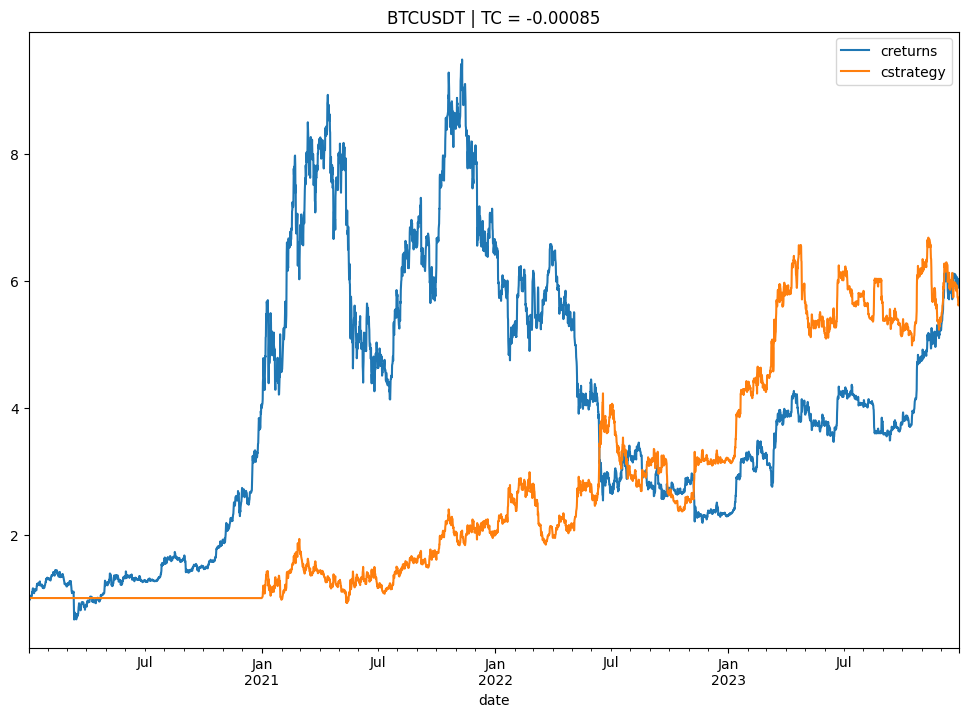

In [166]:
tester.plot_results(leverage = False)

In [164]:
tester.optimize_strategy(
  (5, 30, 5),
  (10, 1000, 50),
  (0.1, 10, 0.3),
  (-1, 1.5, 0.5),
  metric = "Sharpe" # "Multiple"
) # Sharpe

# param_0 = 8 # neighborsCount=8, 
# param_1 = 200 # emaPeriod 20
# param_2 = 8.0 # relativeWeight=8.0, 0.1 - 8
# param_3 = 0.1 # regimeThreshold=0.1, #-1 to 1 0.1

# (2, 10, 2),
# (50, 500, 100),
# (0.1, 8, 0.3),
# (-1, 1, 0.5),

[ 5 10 15 20 25] [ 10  60 110 160 210 260 310 360 410 460 510 560 610 660 710 760 810 860
 910 960] [0.1 0.4 0.7 1.  1.3 1.6 1.9 2.2 2.5 2.8 3.1 3.4 3.7 4.  4.3 4.6 4.9 5.2
 5.5 5.8 6.1 6.4 6.7 7.  7.3 7.6 7.9 8.2 8.5 8.8 9.1 9.4 9.7] [-1.  -0.5  0.   0.5  1. ]
Params: [5.0, 10.0, 0.1, -0.5] | Sharpe: 0.76811
STRATEGY | INSTRUMENT = BTCUSDT, [ 5.  10.   0.1 -0.5]
----------------------------------------------------------------------------------------------------
PERFORMANCE MEASURES:


Multiple (Strategy):         5.623553
Multiple (Buy-and-Hold):     6.02074
--------------------------------------
Out-/Underperformance:       -0.397187


CAGR:                        0.542221
Annualized Mean:             0.433025
Annualized Std:              0.563756
Sharpe Ratio:                0.768108
Sortino Ratio:               1.135112
Maximum Drawdown:            0.522743
Calmar Ratio:                1.037262
Max Drawdown Duration:       220 Days
Kelly Criterion:             1.853088


In [ ]:
tester.visualize_many()

In [ ]:
tester.add_leverage(leverage = 2)

In [ ]:
tester.plot_results(leverage = True)

In [ ]:
tester.results

In [ ]:
tester.results.trades.value_counts()

In [ ]:
tester.results.eff_lev.describe()

In [ ]:
tester.results.eff_lev.plot(figsize = (12, 8))
plt.show()

## Backtesting Robustness: all metrics on all pairs + means

In [ ]:
import pandas as pd
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Define the parameter combinations for different symbols
param_combinations = [
    # btc 1h | multiple | good: rune, blur, sui
    (183, 0.1, 92, 0.01, 0.96),  
    # btc 1h | sharpe |
    (400, 0.15, 140, 0.06, 0.96),
    # ftm 1h | good: dydx
    (44, 0.2, 50, 0.05, 0.96),  
    (49, 0.28, 201, 0.01, 0.93),
    # sol 1h | good: rune, shib, doge
    (53, 0.27, 60, 0.02, 0.87),
    (53, 0.27, 60, 0.02, 0.87),
    # sui 1h |
    (117, 0.42, 110, 0.01, 0.85),  
    (70, 0.45, 115, 0.01, 0.88),
    # eth
    (185, 0.01, 88, 0.09, 0.94),
    (185, 1.3, 125, 0.04, 0.99)
]

# Define a list of symbols to test
# symbols = ["btc", "ftm"]  # Add more symbols here
# symbols = ["btc", "eth", "sol", "avax", "ftm", "bnb", "snx", "uni", "dydx", "doge", "shib", "pepe", "blur", "rune", "inj", "sui"]  # Add more symbols here
symbols = ["btc", "eth", "sol", "avax", "ftm", "bnb", "snx", "uni", "doge", "rune", "inj"]  # same date
# symbols = ["eth", "avax", "bnb", "snx", "uni", "dydx", "doge", "shib", "pepe", "blur", "rune", "inj"] ex
# symbols = ["eth", "avax", "bnb", "snx", "uni", "doge", "rune", "inj"]  # ex same date
# symbols = ["btc", "eth", "avax", "bnb", "snx", "uni", "rune", "inj"]  # runners + btc
# symbols = ["eth", "avax", "bnb", "snx", "uni", "rune", "inj"]  # runners
# symbols = ["dydx", "pepe", "blur", "sui"]  # bleeders
# symbols = ["btc", "dydx", "pepe", "blur", "sui"]  # bleeders + btc

# Initialize an empty list to store the results
results_list = []

# Function to backtest and calculate a performance metric for a given symbol and parameters
def test_symbol(symbol, params, metric_func):
    # Create a Futures_Backtester instance for the symbol and parameters
    tester = Futures_Backtester(filepath=f"/Users/alex/Documents/backtesting/data/{symbol}_1h_futures.csv", symbol=symbol, start="2021-01-01", end="2024-01-01", tc=-0.00085)
    tester.test_strategy(params=params)
    # Calculate and return the selected performance metric
    metric_value = metric_func(tester.results.strategy)
    return symbol, params, metric_value

# Define the list of selected metric functions
selected_metric_funcs = [
    # Add the metric functions you want to use
    tester.calculate_multiple,
    tester.calculate_sharpe,
    tester.calculate_sortino,
    tester.calculate_calmar,
    tester.calculate_max_drawdown,
    tester.calculate_max_dd_duration,
    tester.calculate_kelly_criterion
]

# Set the output directory for saving images
output_directory = '/Users/alex/Documents/backtesting/hawkes/hawkes_everything_same_date_majority'

# Ensure the output directory exists
os.makedirs(output_directory, exist_ok=True)

# Create an empty dictionary to store the mean metric values for each ParamSet and metric function
mean_metrics = {metric_func.__name__: {} for metric_func in selected_metric_funcs}

# Iterate through selected metrics
for metric_func in selected_metric_funcs:
    # Initialize an empty list to store the results
    results_list = []

    # Iterate through symbols and parameter combinations, and store the selected performance metric
    for symbol in symbols:
        for params in param_combinations:
            symbol, params, metric_value = test_symbol(symbol, params, metric_func)
            results_list.append([symbol, params, metric_value])

    # Create a DataFrame from the results_list for visualization
    results_df = pd.DataFrame(results_list, columns=["Symbol", "ParamSet", "Metric"])

    # Calculate the mean performance metric for each ParamSet
    mean_metric_by_param = results_df.groupby("ParamSet")["Metric"].mean().reset_index()

    # Create a list of ParamSet labels with mean performance metric values
    paramset_labels = [
        f"{param} (Mean {metric_func.__name__}: {mean_metric_by_param[mean_metric_by_param['ParamSet'] == param]['Metric'].values[0]:.2f})"
        for param in results_df['ParamSet']
    ]

    # Update the ParamSet column in results_df with the new labels
    results_df['ParamSet'] = paramset_labels

    # Save the mean metric values for the current metric function in the dictionary
    mean_metrics[metric_func.__name__] = mean_metric_by_param.set_index('ParamSet')['Metric'].to_dict()

    # Use Seaborn to visualize the results as a heatmap
    plt.figure(figsize=(12, 11))
    plt.subplot(2, 1, 1)
    pivot_table = results_df.pivot_table(index="Symbol", columns="ParamSet", values="Metric")
    sns.heatmap(pivot_table, annot=True, cmap="YlGnBu", fmt=".2f", cbar=False)
    plt.title(f"{metric_func.__name__} Ratios for Different Symbols and Parameter Combinations")

    # Save the plot as an image in the specified directory
    image_filename = os.path.join(output_directory, f"{metric_func.__name__}_heatmap.png")
    plt.savefig(image_filename)
    plt.close()

# Now, create a final heatmap to visualize the mean metric values for all selected metric functions
mean_metrics_df = pd.DataFrame(mean_metrics)
plt.figure(figsize=(20, 8))
plt.subplot(2, 1, 1)
final_heatmap = sns.heatmap(mean_metrics_df, annot=True, cmap="YlGnBu", fmt=".2f", cbar=True)
plt.title("Mean Metrics for Different Performance Metrics and Parameter Combinations")
plt.tight_layout()

# Save the final plot as an image in the specified directory
final_image_filename = os.path.join(output_directory, "mean_metrics_heatmap.png")
plt.savefig(final_image_filename)
plt.close()

print("Heatmaps have been generated and saved as images.")


## Simple Monte Carlo: random starting dates with a set of pre-optimised params

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Define the parameters for the backtester
filepath = "/Users/alex/Documents/squidward/btc_1h_futures.csv"  # Replace with the actual file path
symbol = "BTCUSDT"  # Replace with the desired symbol
start_date = "2016-01-01"  # Replace with the start date
end_date = "2023-12-01"  # Replace with the end date
tc = -0.00085  # Replace with the desired trading cost

# Define the number of Monte Carlo simulations
num_simulations = 10000

# btc 1h | multiple | good: rune, blur, sui
param_0 = 183  # atr_lookback
param_1 = 0.1  # hawkes kappa
param_2 = 92  # rolling lookback quantile period
param_3 = 0.01  # q1
param_4 = 0.96  # q2
param_5 = 1275  # boll lookback
param_6 = 0.24  # boll div
param_7 = 225  # lookback
param_8 = 1.5  # first_w temporal recent time weighting
param_9 = 6.5  # atr_mult smoothing of profile curve

# Define the parameter combinations for different symbols
param_combinations = [
    # btc 1h | multiple | good: rune, blur, sui
    (183, 0.1, 92, 0.01, 0.96, 1275, 0.24, 225, 1.5, 6.5),
    # # btc 1h | sharpe |
    # (400, 0.15, 140, 0.06, 0.96, 1275, 0.24, 213, 3.7, 5.3),
    # ftm 1h | good: dydx
    # (44, 0.2, 50, 0.05, 0.96, 520, 1.2, 275, 3, 3.5),
    # sol 1h | good: rune, shib, doge
    # (53, 0.27, 60, 0.02, 0.87, 804, 1.3, 250, 4.5, 2.2),
    # sui 1h |
    # (117, 0.42, 110, 0.01, 0.85, 1810, 0.23, 240, 6.3, 0.91)
]

data = pd.read_csv(filepath, parse_dates=["date"], index_col="date")
hours_in_year = 8784 * 2.5

def monte_carlo_simulation(param_combinations, num_simulations=100):
    results = []

    for _ in range(num_simulations):
        # Randomly select an index to choose a parameter combination
        random_index = random.randint(0, len(param_combinations) - 1)
        random_params = param_combinations[random_index]

        # Randomly select a start index within the dataset
        start_index = random.randint(0, len(data) - (hours_in_year + random_params[5]))

        # Convert the random start index to a datetime start date
        random_start_date = data.index[start_index]

        # Create a new instance of the backtester with the random start date and parameters
        backtester = Futures_Backtester(filepath, symbol, str(random_start_date.date()), end_date, tc)
        backtester.test_strategy(params=random_params)

        # Record performance metrics
        metrics = [
            backtester.calculate_multiple(backtester.results["strategy"]),
            backtester.calculate_sharpe(backtester.results["strategy"]),
            backtester.calculate_sortino(backtester.results["strategy"]),
            backtester.calculate_calmar(backtester.results["strategy"]),
            backtester.calculate_max_drawdown(backtester.results["strategy"]),
            backtester.calculate_max_dd_duration(backtester.results["strategy"]),
            backtester.calculate_kelly_criterion(backtester.results["strategy"])
        ]

        results.append(metrics)

    return results

# Example usage:
# Perform the Monte Carlo simulation
simulations = monte_carlo_simulation(param_combinations, num_simulations=num_simulations)

# Analyze the simulation results
avg_metrics = [sum(metric[i] for metric in simulations) / len(simulations) for i in range(len(simulations[0]))]
print("Average Multiple:", avg_metrics[0])
print("Average Sharpe Ratio:", avg_metrics[1])
print("Average Sortino Ratio:", avg_metrics[2])
print("Average Calmar Ratio:", avg_metrics[3])
print("Average Max Drawdown:", avg_metrics[4])
print("Average Max Drawdown Duration:", avg_metrics[5])
print("Average Kelly Criterion:", avg_metrics[6])

# Analyze the simulation results
metrics = [[metric[i] for metric in simulations] for i in range(len(simulations[0]))]

# Find the 10 lowest readings for each metric
lowest_readings = [sorted(metric)[:10] for metric in metrics]

# Display the 10 lowest readings for each metric
metrics_names = ['Multiple', 'Sharpe', 'Sortino', 'Calmar', 'Max Drawdown', 'Max DD Duration', 'Kelly Criterion']
for i, metric_name in enumerate(metrics_names):
    print(f"{metric_name}: {lowest_readings[i]}")

# Create histograms for each metric
n_bins = 80  # Number of bins for each histogram

# Create a figure with subplots for each metric
fig, axs = plt.subplots(2, 4, figsize=(18, 8))
fig.suptitle('Monte Carlo Simulation Results', fontsize=16)

for i, metric_name in enumerate(metrics_names):
    row = i // 4
    col = i % 4

    metric_data = [sim[i] for sim in simulations]
    mean = np.mean(metric_data)
    std_dev = np.std(metric_data)

    axs[row, col].hist(metric_data, bins=n_bins, color='dodgerblue', alpha=0.7)
    axs[row, col].axvline(mean, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.2f}')
    axs[row, col].axvline(mean - std_dev, color='green', linestyle='dotted', linewidth=2, label=f'Std Dev: {std_dev:.2f}')
    axs[row, col].axvline(mean + std_dev, color='green', linestyle='dotted', linewidth=2)
    axs[row, col].axvline(mean - 2 * std_dev, color='purple', linestyle='dotted', linewidth=2, label=f'2 Std Dev: {mean - 2 * std_dev:.2f}')
    axs[row, col].axvline(mean + 2 * std_dev, color='purple', linestyle='dotted', linewidth=2, label=f'2 Std Dev: {mean + 2 * std_dev:.2f}')
    # Add tooltip labels for ±2 standard deviations
    axs[row, col].annotate(f'2 Std Dev: {mean - 2 * std_dev:.2f}', 
                           xy=(mean - 2 * std_dev, axs[row, col].get_ylim()[1]), xycoords='data',
                           xytext=(0, 10), textcoords='offset points',
                           arrowprops=dict(arrowstyle="->", linestyle='dotted', color='purple'),
                           color='purple', ha='center')
    
    axs[row, col].annotate(f'2 Std Dev: {mean + 2 * std_dev:.2f}', 
                           xy=(mean + 2 * std_dev, axs[row, col].get_ylim()[1]), xycoords='data',
                           xytext=(0, 10), textcoords='offset points',
                           arrowprops=dict(arrowstyle="->", linestyle='dotted', color='purple'),
                           color='purple', ha='center')


    axs[row, col].set_title(metric_name)
    axs[row, col].set_xlabel('Value')
    axs[row, col].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.legend(loc='upper right')

# Save the plot as an image
plt.savefig('/Users/alex/Downloads/monte_carlo_histograms_sol_1h_futures_53_sol_10000.png')

# Show the plot
plt.show()